In [1]:
# open eval/cog-plausibility/en/correlation_results.tsv

from pandas import read_csv
import ast
from transformers import AutoTokenizer

remove_objectives = ['min-mean-post-merge', 'frequency-mean-post-merge', 'thresholdBX', 'thresholdM']

def fix_name(tokenizer_name):
    if "bytelevel" in tokenizer_name:
        return "bytelevel_NA_NA_256"
    elif "frequencymulti_" in tokenizer_name:
        return "frequencymulti_NA_frequencymulti_" + tokenizer_name.split("_")[1]
    elif "frequency_" in tokenizer_name:
        return "frequency_NA_frequency_" + tokenizer_name.split("_")[1]
    elif "mutual-information" in tokenizer_name:
        return "mutual-information_NA_mutual-information_" + tokenizer_name.split("_")[1]
    else:
        return tokenizer_name
    
def prepare_df(df):
    df['tokenizer'] = df['tokenizer'].apply(fix_name)
    df['tokenizer'] = df['tokenizer'].apply(lambda x: x.split("_")[0:4])
    df['tokenizer_type'] = df['tokenizer'].apply(lambda x: x[0])
    df['vocab_size'] = df['tokenizer'].apply(lambda x: x[-1])
    df['signal'] = df['tokenizer'].apply(lambda x: x[1])
    df['objective'] = df['tokenizer'].apply(lambda x: x[2])
    df['tokenizer'] = df['tokenizer'].apply(lambda x: '_'.join(x[0:4]))
    df = df[~(df['objective'].isin(remove_objectives))]
    return df

file = "../eval/cog-plausibility/en/NEW_correlation_results.csv"
df = read_csv(file, sep=", ")
df = df.rename(columns={"Tokenizer": "tokenizer"})
df_cog = prepare_df(df)

file = "../tokenizer_stats_fineweb.csv"
df = read_csv(file, sep=",")
df.rename(columns={"tokenizer_name": "tokenizer"}, inplace=True)
df_fert = prepare_df(df)

file = "../tokenizer_stats_common.csv"
df = read_csv(file, sep=",")
df.rename(columns={"tokenizer_name": "tokenizer"}, inplace=True)
df_fert_multi = prepare_df(df)



/tmp/ipykernel_177832/3192496459.py:33: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = read_csv(file, sep=", ")


In [2]:
t = AutoTokenizer.from_pretrained("InfoTokenizers/tokenizers", subfolder='fw57M_Entropy_thresholdB_32000')

In [3]:
t.tokenize('hello world')

['Ġhe', '##llo', 'Ġworld']

In [11]:
# Plot category=words and measure="NumSplits vs Acc" for vocab_size=8064
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

import seaborn as sns

def plot_correlation(category, measure, vocab_size):
    fig, ax = plt.subplots(figsize=(6, 4))
    df = df_cog[(df_cog['Category'] == category) & (df_cog['vocab_size'] == vocab_size)]
    sns.barplot(x='tokenizer', y=measure, data=df, palette="Blues", ax=ax, hue='objective')
    labels = [x + ' ' + y for x, y in zip(df['tokenizer_type'], df['signal'])]
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_title(f"{measure} for {category} with vocab_size={vocab_size}")
    plt.xticks(rotation=45, ha='right')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Objective')

    plt.show()

def plot_measure(measure, vocab_size):
    fig, ax = plt.subplots(figsize=(6, 4))
    df = df_fert[(df_fert['vocab_size'] == vocab_size)]
    sns.barplot(x='tokenizer', y=measure, data=df, palette="Blues", ax=ax, hue='objective')
    labels = [x + ' ' + y for x, y in zip(df['tokenizer_type'], df['signal'])]
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_title(f"{measure} for {vocab_size}")
    plt.xticks(rotation=45, ha='right')

def plot_measure_multi_single_lang(measure, language):
    fig, ax = plt.subplots(figsize=(6, 4))
    df = df_fert_multi[(df_fert_multi['language'] == language)]
    df = df.sort_values(by='vocab_size', ascending=False)
    sns.lineplot(x='vocab_size', y=measure, data=df, palette="Blues", ax=ax, hue='objective')
    ax.set_title(f"{measure} for {language}")
    plt.xticks(rotation=45, ha='right')

def plot_measure_single_vocab(measure, vocab_size):
    fig, ax = plt.subplots(figsize=(12, 4))
    df = df_fert_multi[(df_fert_multi['vocab_size'] == str(vocab_size))]
    df = df.sort_values(by=measure, ascending=True)
    sns.barplot(x='language', y=measure, data=df, palette="Blues", ax=ax, hue='objective')
    ax.set_title(f"{measure} for {vocab_size=}")
    plt.xticks(rotation=45, ha='right')

def plot_continuation_distribution(tokenizer_name):
    fig, ax = plt.subplots(figsize=(6, 4))
    continuations = df_fert[(df_fert['tokenizer'] == tokenizer_name)]['split_lengths_distribution'].values[0]
    continuations = continuations.replace("defaultdict(<class 'int'>, ","").replace(")","")
    continuations = ast.literal_eval(continuations)
    continuations = {int(k): v for k, v in continuations.items() if k < 20}
    continuations = dict(sorted(continuations.items()))
    x = list(continuations.keys())
    y = list(continuations.values())
    ax.bar(x, y)
    ax.set_xlabel('Continuation Length')
    ax.set_ylabel('Frequency')
    ax.set_title(f"Continuation Length Distribution for {tokenizer_name}")
    x_ticks = list(range(1, 20))
    ax.set_xticks(x_ticks)
    plt.show()

def get_length_distribution(tokenizer_name):
    tokenizer = AutoTokenizer.from_pretrained("InfoTokenizers/tokenizers", subfolder=tokenizer_name)
    vocab = tokenizer.get_vocab()
    lengths = {i : 0 for i in range(1, 20)}
    for token in vocab:
        length = len(token.replace('##', ''))
        if length not in lengths:
            continue
        lengths[length] += 1
    lengths = dict(sorted(lengths.items()))
    return lengths

def plot_grouped_bar_plot(list_of_lengths, names):
    fig, ax = plt.subplots(figsize=(12, 4))
    x = list(range(len(list_of_lengths[0])))
    width = 0.2
    for i, lengths in enumerate(list_of_lengths):
        y = list(lengths.values())
        ax.bar([p + width * i for p in x], y, width=width, label=names[i])
    ax.set_xticks([p + width * (len(list_of_lengths) - 1) / 2 for p in x])
    ax.set_xticklabels(list_of_lengths[0].keys())
    ax.legend()
    plt.show()

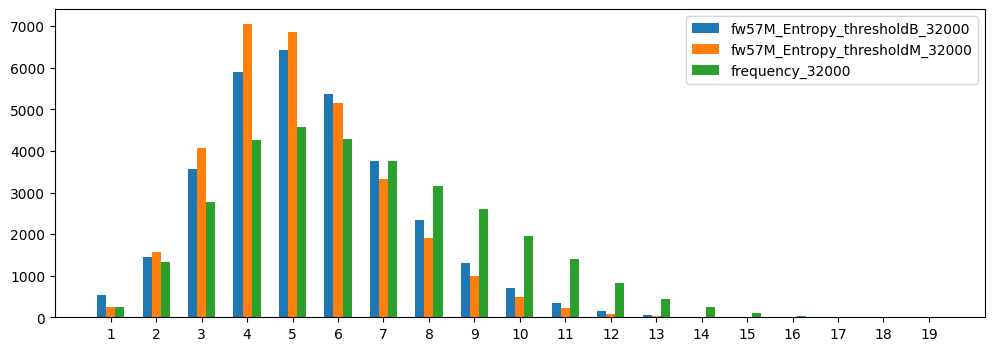

In [12]:
tokenizers = ["fw57M_Entropy_thresholdB_32000", "fw57M_Entropy_thresholdM_32000", "frequency_32000"]
lengths = []
for tokenizer in tokenizers:
    lengths.append(get_length_distribution(tokenizer))
plot_grouped_bar_plot(lengths, tokenizers)



Number of languages where thresholdB is better than frequencymulti: 15


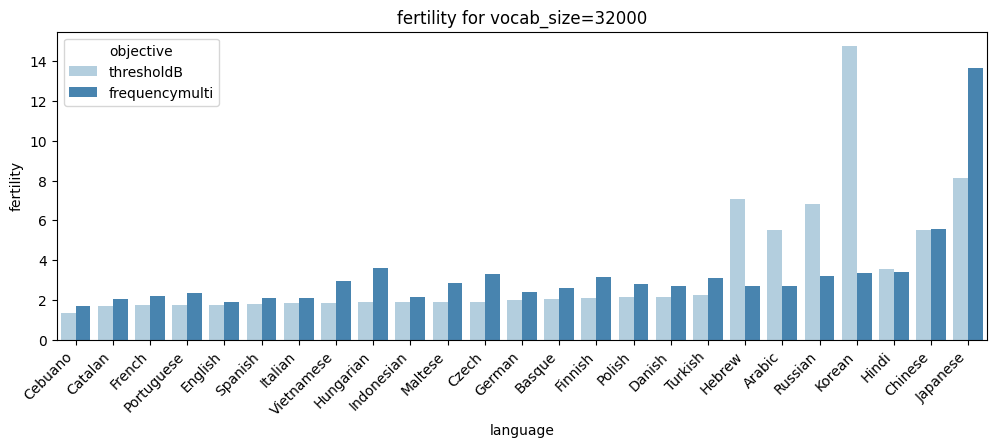

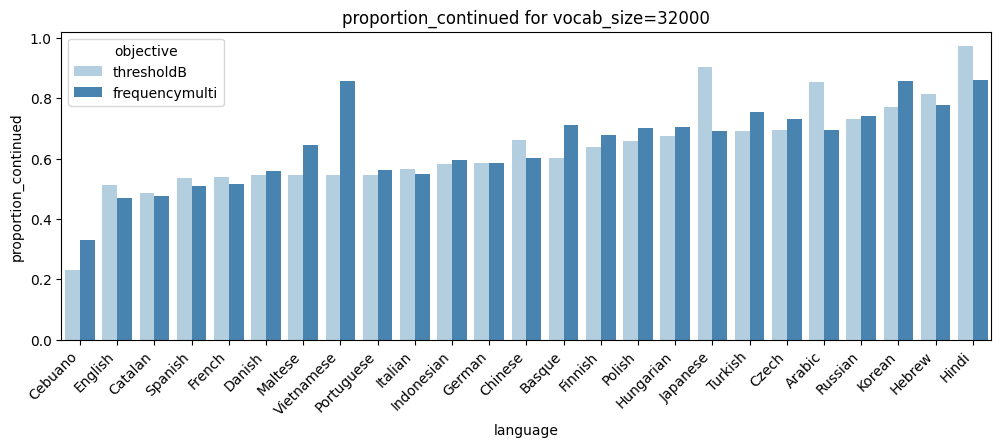

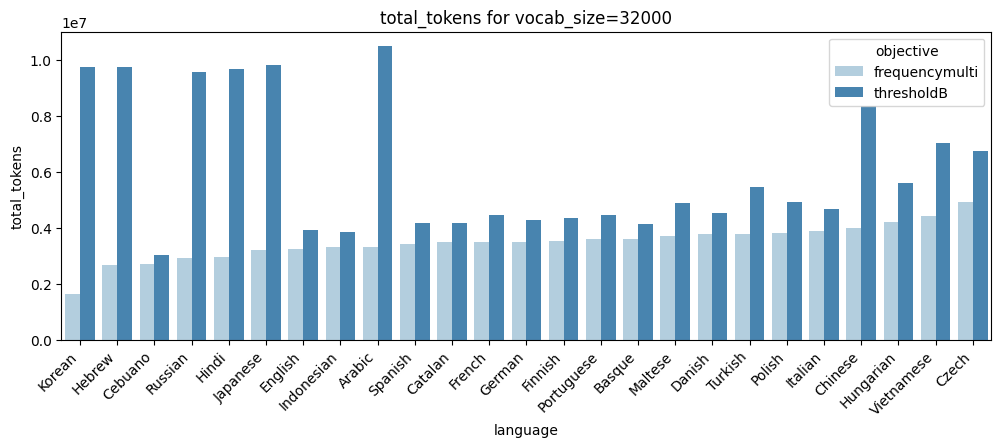

In [14]:
plot_measure_single_vocab("fertility", 32000)
plot_measure_single_vocab("proportion_continued", 32000)
plot_measure_single_vocab("total_tokens", 32000)

languages = df_fert_multi['language'].unique()
tmp_df = df_fert_multi[df_fert_multi['vocab_size'] == '32000'].sort_values(by='language')
# number of languages where tmp_df['fertility'] is bigger for 'objective'=='thresholdB' than 'frquencymulti'
threshold_scores = tmp_df[tmp_df['objective'] == 'thresholdB']['proportion_continued'].reset_index(drop=True)
frequency_scores = tmp_df[tmp_df['objective'] == 'frequencymulti']['proportion_continued'].reset_index(drop=True)
threshold_better = threshold_scores < frequency_scores
print(f"Number of languages where thresholdB is better than frequencymulti: {threshold_better.sum()}")


/tmp/ipykernel_272085/2481317737.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')


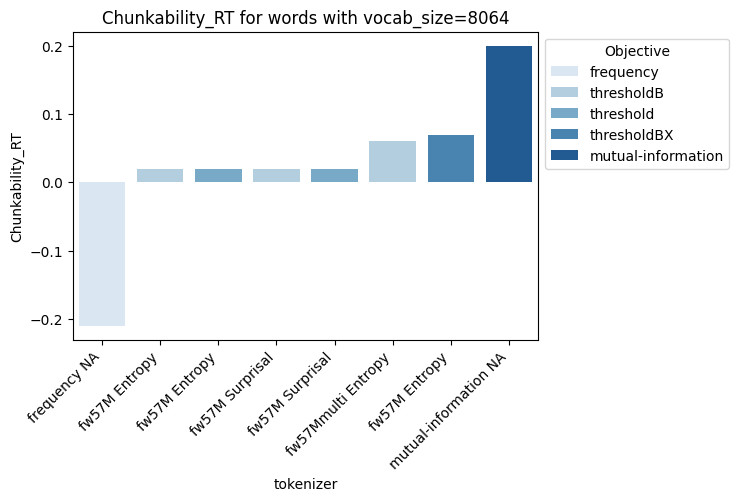

/tmp/ipykernel_272085/2481317737.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')


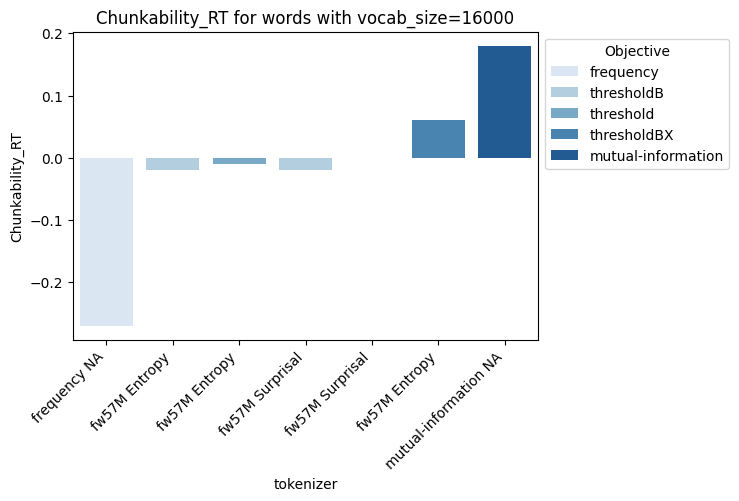

/tmp/ipykernel_272085/2481317737.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')


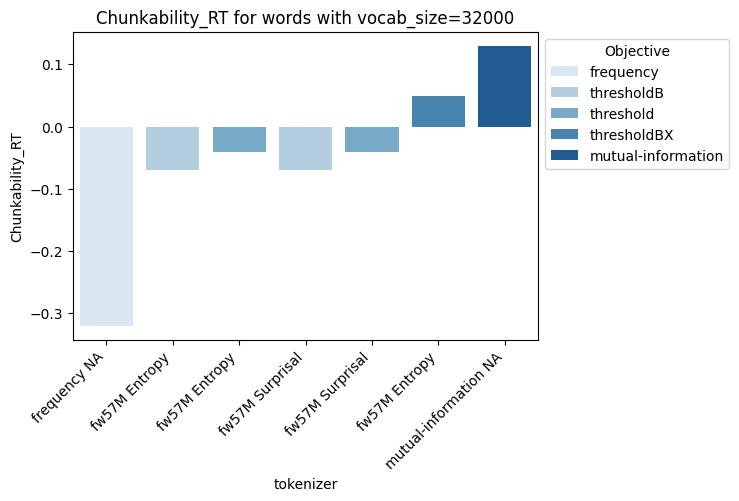

/tmp/ipykernel_272085/2481317737.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')


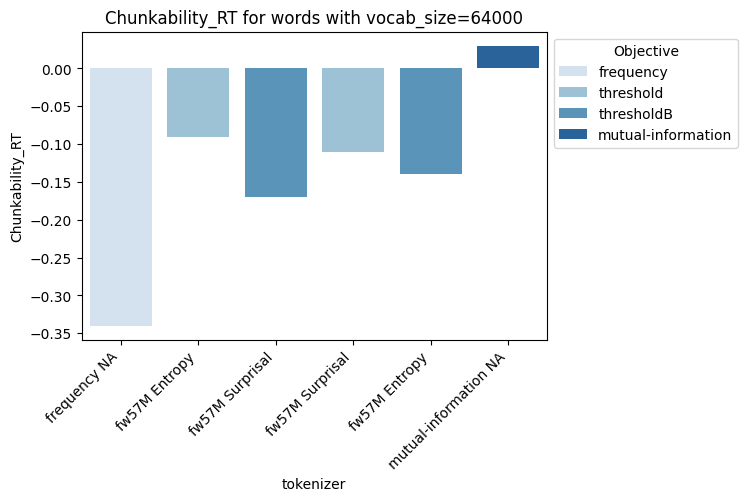

/tmp/ipykernel_272085/2481317737.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')


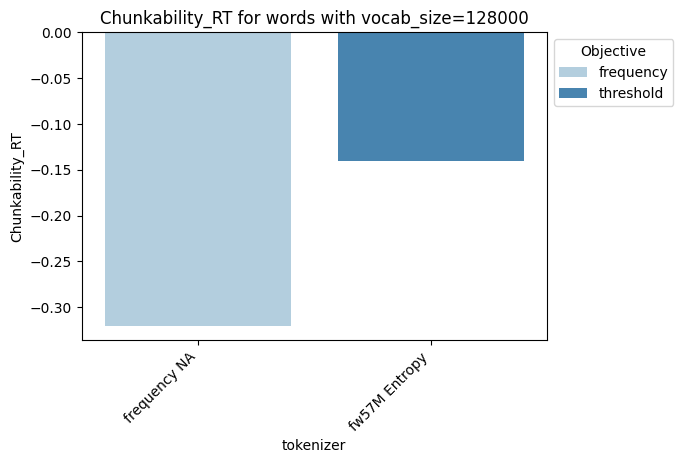

In [19]:
for vocab_size in ['8064', '16000', '32000', '64000', '128000']:
    plot_correlation('words', 'Chunkability_RT', vocab_size)

/tmp/ipykernel_621604/1188092660.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')
/tmp/ipykernel_621604/1188092660.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')
/tmp/ipykernel_621604/1188092660.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')
/tmp/ipykernel_621604/1188092660.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')
/tmp/ipykernel_621604/1188092660.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of

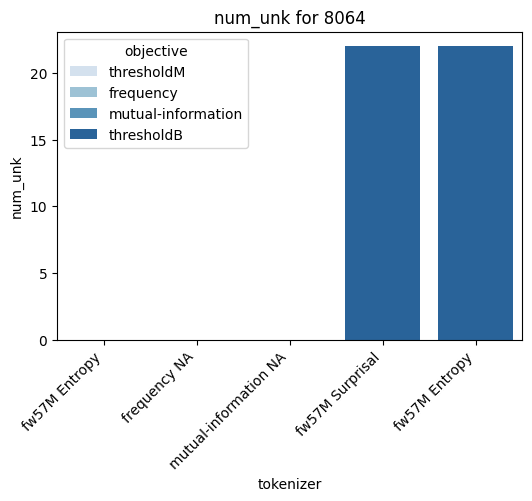

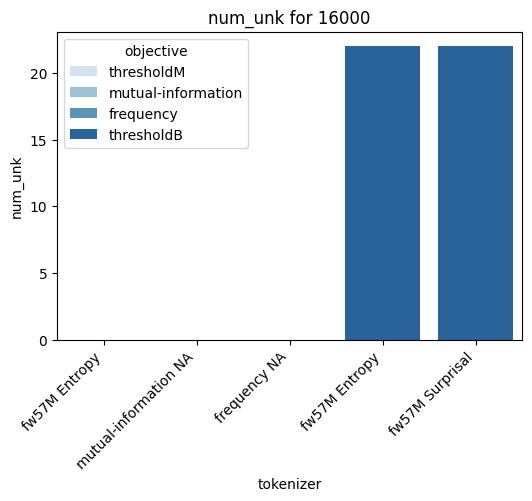

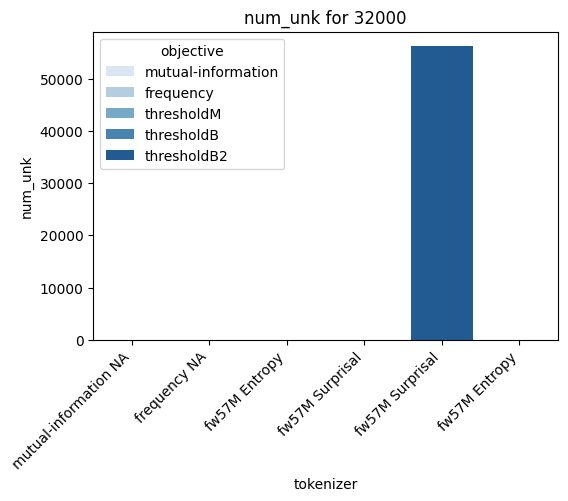

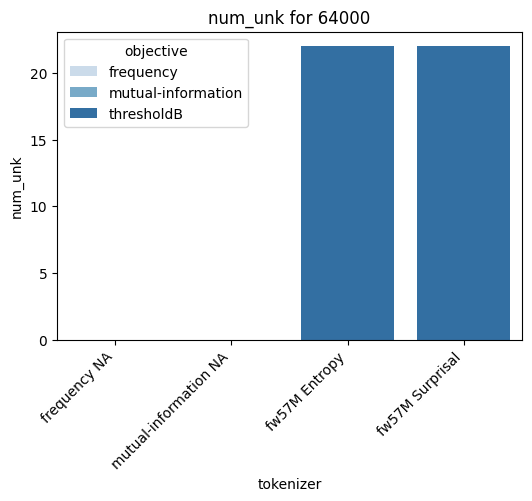

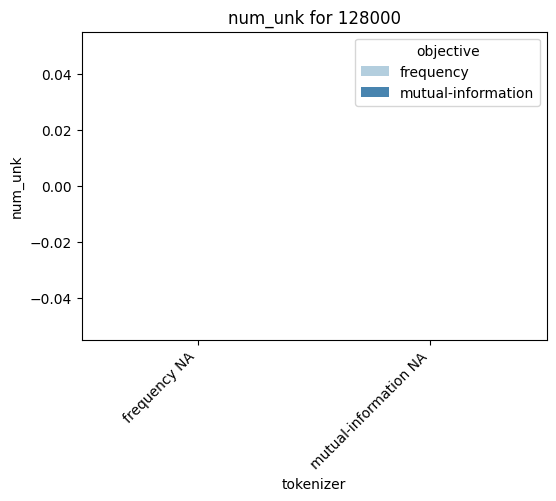

In [5]:
for vocab_size in ['8064', '16000', '32000', '64000', '128000']:
    plot_measure('num_unk', vocab_size)

/tmp/ipykernel_621604/1188092660.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')
/tmp/ipykernel_621604/1188092660.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')
/tmp/ipykernel_621604/1188092660.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')
/tmp/ipykernel_621604/1188092660.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')
/tmp/ipykernel_621604/1188092660.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of

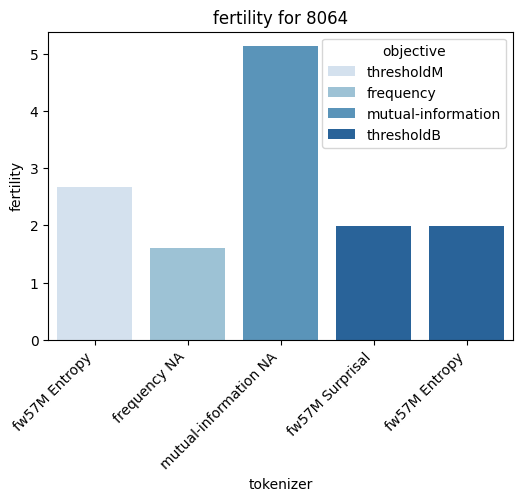

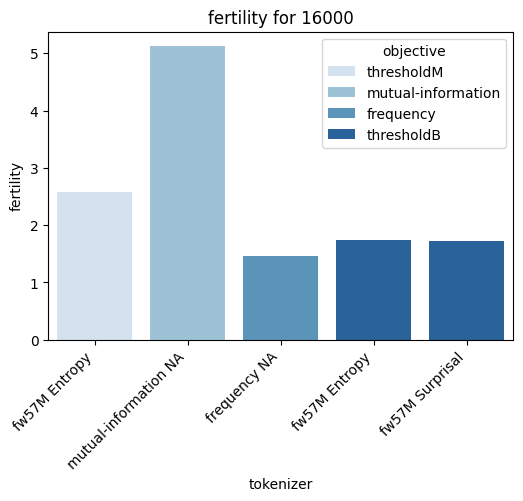

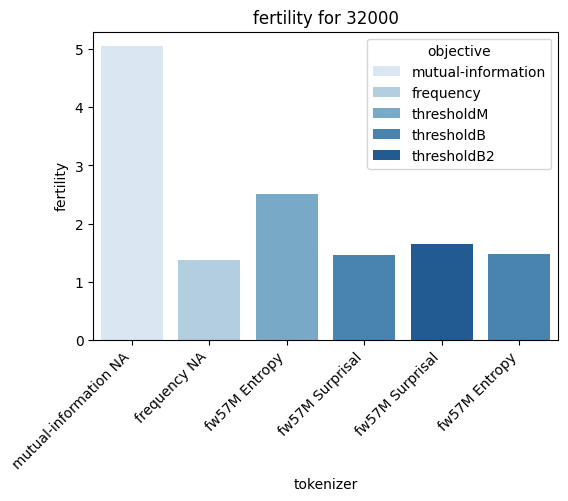

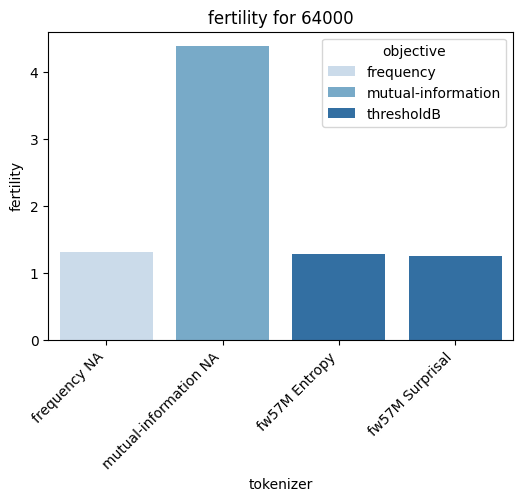

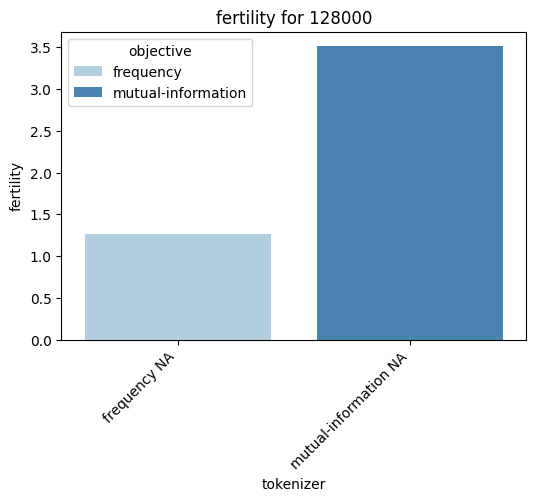

In [8]:
for vocab_size in ['8064', '16000', '32000', '64000', '128000']:
    plot_measure('fertility', vocab_size)

/tmp/ipykernel_272085/2481317737.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='tokenizer', y=measure, data=df, palette="Blues", ax=ax)
/tmp/ipykernel_272085/2481317737.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')
/tmp/ipykernel_272085/2481317737.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='tokenizer', y=measure, data=df, palette="Blues", ax=ax)
/tmp/ipykernel_272085/2481317737.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabe

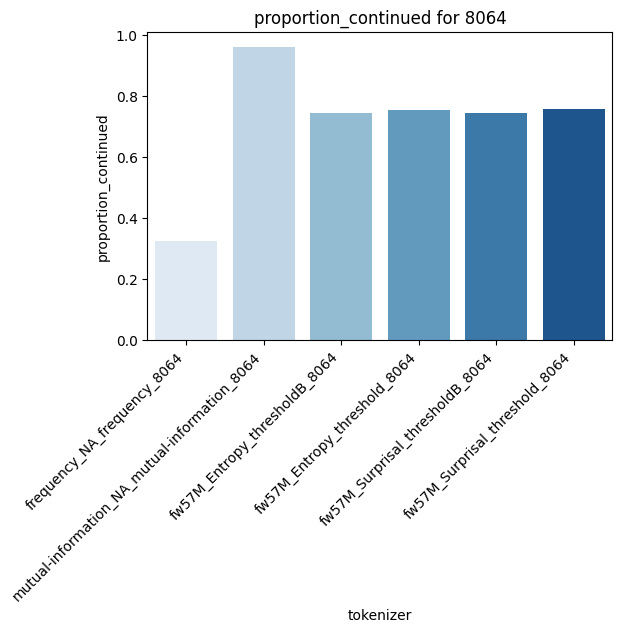

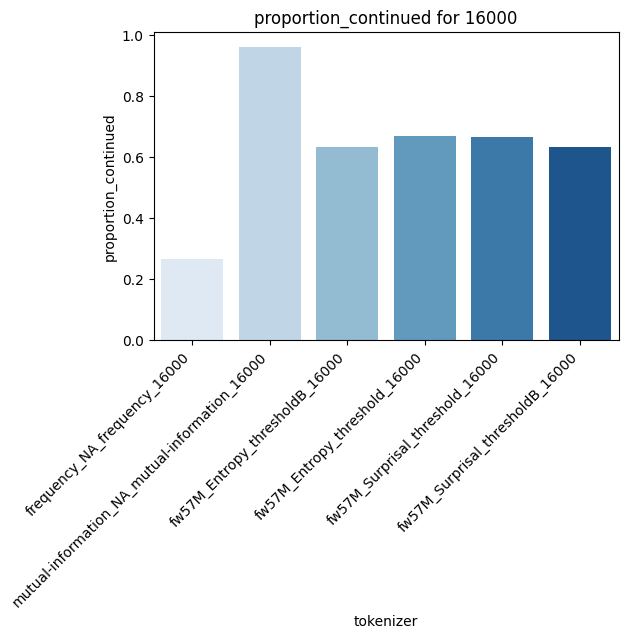

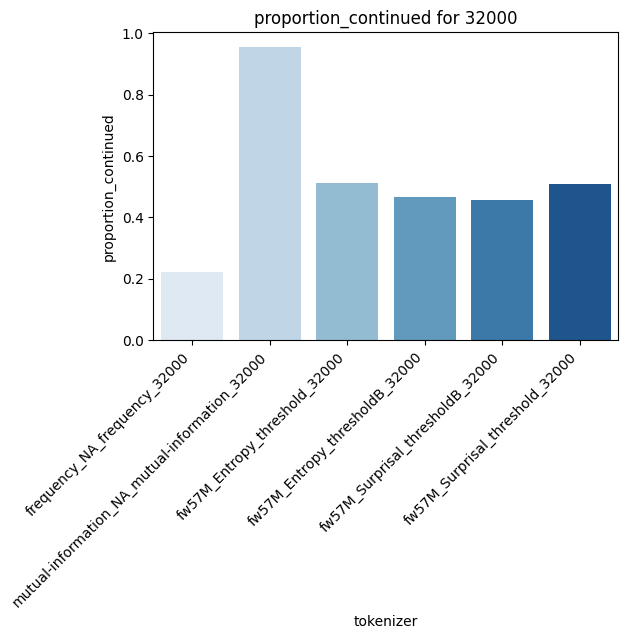

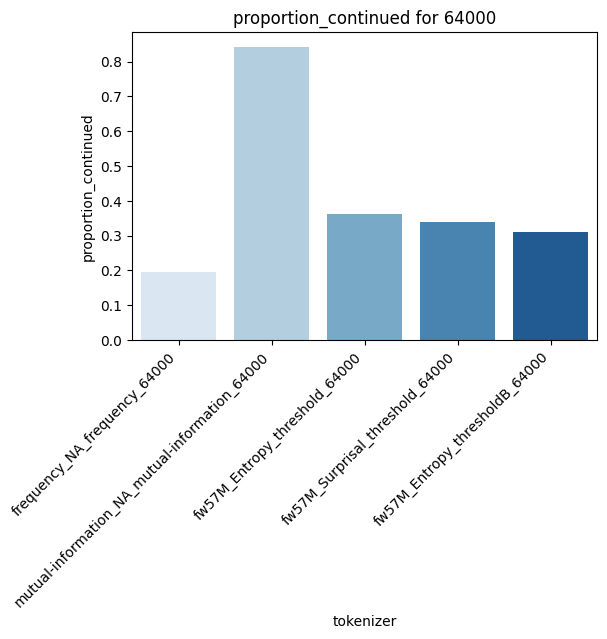

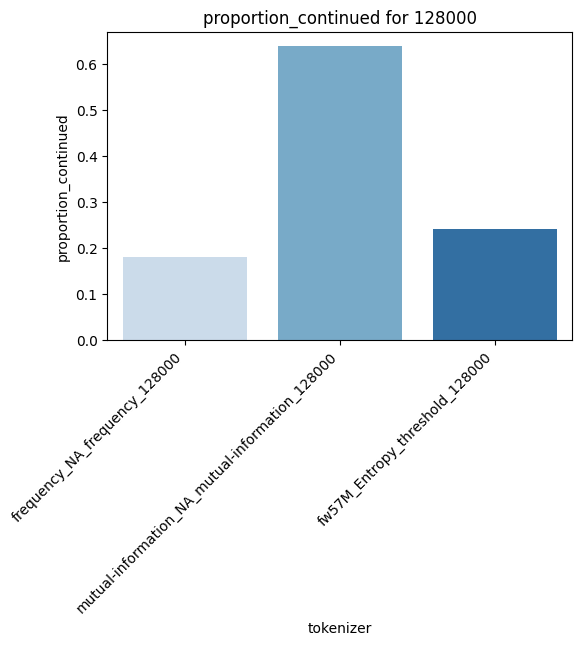

In [15]:
for vocab_size in ['8064', '16000', '32000', '64000', '128000']:
    plot_measure('proportion_continued', vocab_size)

In [9]:
df

,tokenizer,fertility,proportion_continued,total_split_words,total_words,total_tokens,split_lengths_distribution,tokenizer_type,vocab_size,signal,objective
0,frequency_NA_frequency_Space Probability,1.540617,0.308342,23895314,77496192,196901307,"defaultdict(<class 'int'>, {1: 53600878, 2: 13...",frequency,Space Probability,NA,frequency
2,frequency_NA_frequency_Surprisal,1.325820,0.211510,16391188,77496192,180255405,"defaultdict(<class 'int'>, {1: 61105004, 2: 11...",frequency,Surprisal,NA,frequency
6,frequency_NA_frequency_Entropy,1.242839,0.172111,13337985,77496192,173824687,"defaultdict(<class 'int'>, {1: 64158207, 2: 10...",frequency,Entropy,NA,frequency
9,frequency_NA_frequency_Entropy,1.231601,0.166946,12937711,77496169,172155160,"defaultdict(<class 'int'>, {1: 64558458, 2: 10...",frequency,Entropy,NA,frequency
12,frequency_NA_frequency_Space Probability,1.273580,0.186650,14464644,77496192,176206976,"defaultdict(<class 'int'>, {1: 63031548, 2: 10...",frequency,Space Probability,NA,frequency
13,frequency_NA_frequency_Entropy,1.273580,0.186650,14464644,77496192,176206976,"defaultdict(<class 'int'>, {1: 63031548, 2: 10...",frequency,Entropy,NA,frequency
14,frequency_NA_frequency_Surprisal,1.410408,0.251193,19466501,77496192,186810615,"defaultdict(<class 'int'>, {1: 58029691, 2: 12...",frequency,Surprisal,NA,frequency
16,frequency_NA_frequency_Surprisal,1.619588,0.405036,31388638,77495925,190961208,"defaultdict(<class 'int'>, {1: 46107287, 2: 20...",frequency,Surprisal,NA,frequency
21,frequency_NA_frequency_Space Probability,1.410408,0.251193,19466501,77496192,186810615,"defaultdict(<class 'int'>, {1: 58029691, 2: 12...",frequency,Space Probability,NA,frequency
23,frequency_NA_frequency_Entropy,1.325820,0.211510,16391188,77496192,180255405,"defaultdict(<class 'int'>, {1: 61105004, 2: 11...",frequency,Entropy,NA,frequency
